In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
transform = transforms.ToTensor()

In [ ]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.59MB/s]


In [ ]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

# Variables ( Trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop epochs
for i in range(epochs):

    trn_corr = 0
    tst_corr = 0


    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        # Apply the model
        y_pred = model(X_train)  # we not flatten X-train here
        loss = criterion(y_pred, y_train)


        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()  # Trure 1 / False 0 sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i}  batch: {b} loss: {loss.item()}')

    # Detach the loss tensor before appending to the list
    train_losses.append(loss.detach())
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    # Calculate the loss for the test batch within the no_grad context
    test_loss = criterion(y_val, y_test)
    # Detach the test_loss tensor before appending to the list
    test_losses.append(test_loss.detach())
    test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training took {total/60} minutes')

epoch: 0  batch: 600 loss: 0.040556274354457855
epoch: 0  batch: 1200 loss: 0.08253474533557892
epoch: 0  batch: 1800 loss: 0.3647049069404602
epoch: 0  batch: 2400 loss: 0.018250251188874245
epoch: 0  batch: 3000 loss: 0.008067040704190731
epoch: 0  batch: 3600 loss: 0.001166942878626287
epoch: 0  batch: 4200 loss: 0.5255253911018372
epoch: 0  batch: 4800 loss: 0.03260819613933563
epoch: 0  batch: 5400 loss: 0.007468158844858408
epoch: 0  batch: 6000 loss: 0.03889675810933113
epoch: 1  batch: 600 loss: 0.032828204333782196
epoch: 1  batch: 1200 loss: 0.04554177075624466
epoch: 1  batch: 1800 loss: 0.005784796085208654
epoch: 1  batch: 2400 loss: 0.02235613949596882
epoch: 1  batch: 3000 loss: 0.21643038094043732
epoch: 1  batch: 3600 loss: 0.00501451687887311
epoch: 1  batch: 4200 loss: 0.00045869071618653834
epoch: 1  batch: 4800 loss: 0.0019295118981972337
epoch: 1  batch: 5400 loss: 0.0008596166153438389
epoch: 1  batch: 6000 loss: 0.08304359018802643
epoch: 2  batch: 600 loss: 0.0

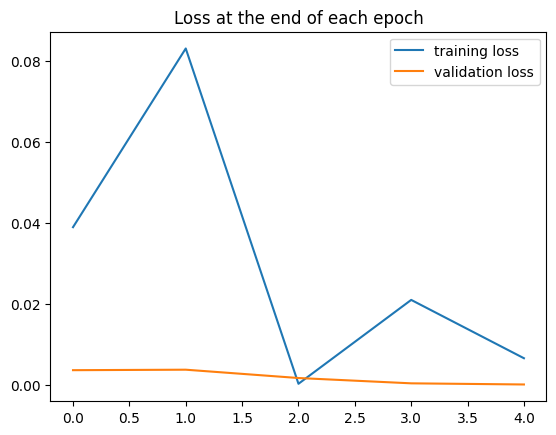

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()


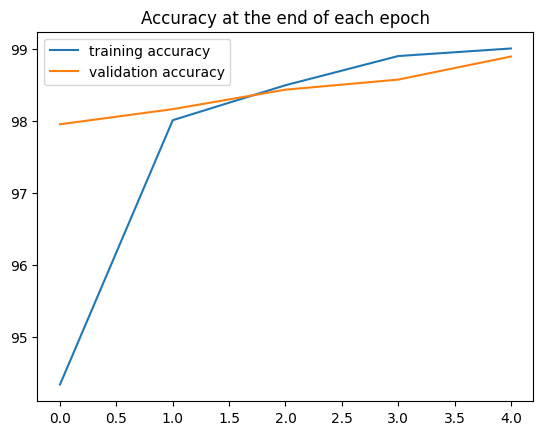

In [ ]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();
plt.show()


In [ ]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [ ]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 977    3    1    0    0    2    4    1    4    0]
 [   0 1130    2    0    0    0    1    4    0    3]
 [   0    1 1022    0    0    0    0    4    2    0]
 [   0    0    3 1007    0    7    0    2    2    2]
 [   0    0    1    0  971    0    1    0    0    5]
 [   0    0    0    1    0  879    7    0    1    5]
 [   1    1    0    0    4    2  944    0    1    0]
 [   1    0    3    0    0    0    0 1013    1    2]
 [   1    0    0    2    1    1    1    1  962    8]
 [   0    0    0    0    6    1    0    3    1  984]]


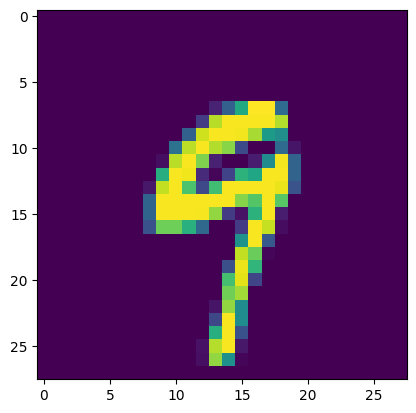

In [ ]:
# single image for test
plt.imshow(test_data[2019][0].reshape(28,28))
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[2019][0].view(1,1,28,28))
new_prediction.argmax()

tensor(9)

In [ ]:
torch.save(model.state_dict(), 'yogesh212222110055.pt')

In [ ]:
new_model = ConvolutionalNetwork() # Replace Model with ConvolutionalNetwork
new_model.load_state_dict(torch.load('yogesh212222110055.pt'))
new_model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)